In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

**Sequence Length - 20**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10, Loss: 2.160202049843142, Validation Loss: 2.1385059845700596, Validation Accuracy: 0.3599193096492211
Epoch 20, Loss: 2.1129123475178178, Validation Loss: 2.113979151655187, Validation Accuracy: 0.3678583436064104
Epoch 30, Loss: 2.081963520708675, Validation Loss: 2.0981772863105737, Validation Accuracy: 0.37229183010198363
Epoch 40, Loss: 2.057279561537815, Validation Loss: 2.0961233873991056, Validation Accuracy: 0.3728880421382943
Epoch 50, Loss: 2.0372787877977134, Validation Loss: 2.096289912107274, Validation Accuracy: 0.3748694385296425
Epoch 60, Loss: 2.01975813275497, Validation Loss: 2.1012992791177485, Validation Accuracy: 0.375555306511263
Epoch 70, Loss: 2.0035649653111665, Validation Loss: 2.106412120133519, Validation Accuracy: 0.3753580634315813
Epoch 80, Loss: 1.9893388894701305, Validation Loss: 2.1131231550231995, Validation Accuracy: 0.37275804101759497
Epoch 90, Loss: 1.9764072924630094, Validation Loss: 2.1112843094649016, Validation Accuracy: 0.3723097

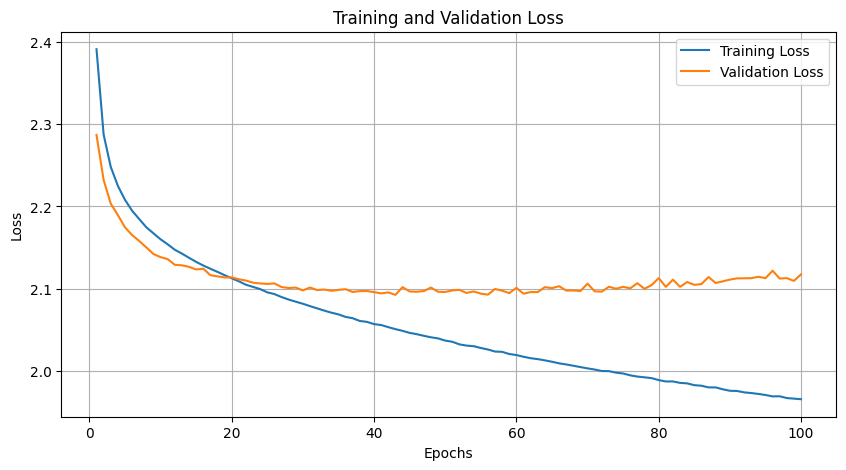

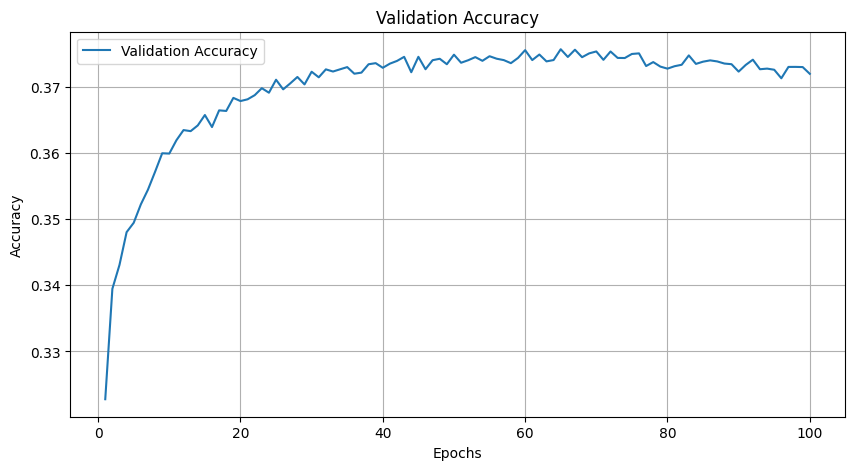

Predicted next character: 'o'
Training time:4652.928606033325 seconds
Trainable parameters: 1202753
Total trainable parameters in the model: 1202753


In [2]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded.permute(1, 0, 2))  # Permute for Transformer
        output = self.fc(transformer_output[-1, :, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 2
nhead = 1
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            val_loss += criterion(outputs, targets).item()

    end_time = time.time()
    training_time = end_time - start_time

    # Calculate Epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    # Append loss and accuracy values
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # Print Epoch statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_int[c] for c in initial_str[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
total_complexity = 0
for p in model.parameters():
    total_complexity += torch.prod(torch.tensor(p.shape))


# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"Trainable parameters: {count_parameters(model)}")
print(f"Total trainable parameters in the model: {total_complexity}")

Sequence Length - 30

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10, Loss: 2.213128932628287, Validation Loss: 2.1975846982727227, Validation Accuracy: 0.34496330797541613
Epoch 20, Loss: 2.169802896366404, Validation Loss: 2.1789056434757192, Validation Accuracy: 0.3496882186548798
Epoch 30, Loss: 2.139786545890402, Validation Loss: 2.168066309842992, Validation Accuracy: 0.35216722776848836
Epoch 40, Loss: 2.1156746644742586, Validation Loss: 2.1656730238623956, Validation Accuracy: 0.35389760302681184
Epoch 50, Loss: 2.0927212928911767, Validation Loss: 2.1669209412439625, Validation Accuracy: 0.35378104925293513
Epoch 60, Loss: 2.073162325654164, Validation Loss: 2.1784515739239567, Validation Accuracy: 0.35301896688527973
Epoch 70, Loss: 2.05532077761881, Validation Loss: 2.1779858626925392, Validation Accuracy: 0.35301896688527973
Epoch 80, Loss: 2.0387090642306562, Validation Loss: 2.1817305850627022, Validation Accuracy: 0.35217171060594515
Epoch 90, Loss: 2.0241881368732013, Validation Loss: 2.2012170899960752, Validation Accuracy: 0.

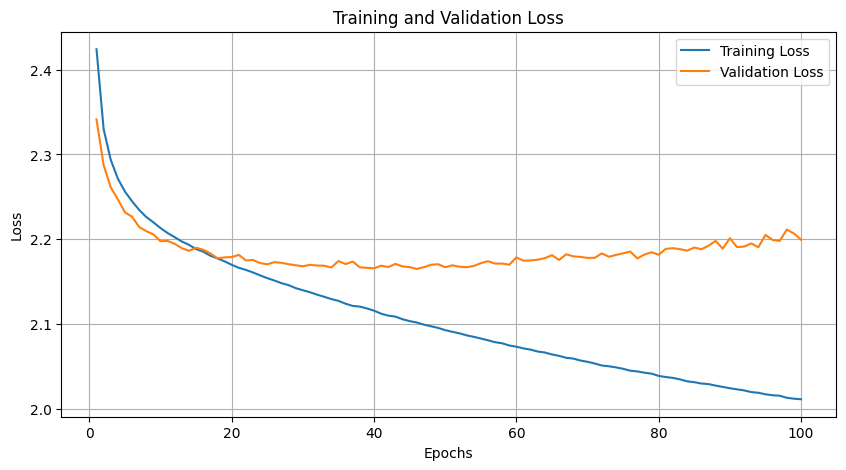

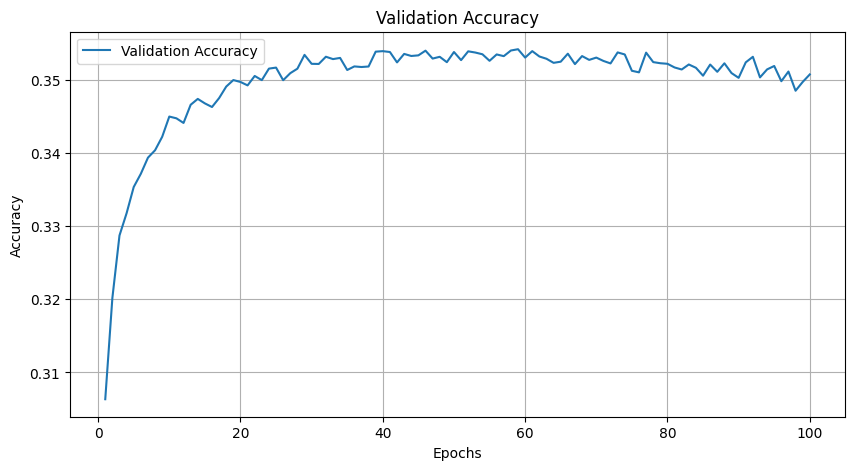

Predicted next character: 'n'
Training time:4867.2712552547455 seconds
Trainable parameters: 1202753
Total trainable parameters in the model: 1202753


In [3]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 30
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded.permute(1, 0, 2))  # Permute for Transformer
        output = self.fc(transformer_output[-1, :, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 2
nhead = 1
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            val_loss += criterion(outputs, targets).item()

    end_time = time.time()
    training_time = end_time - start_time

    # Calculate Epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    # Append loss and accuracy values
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # Print Epoch statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_int[c] for c in initial_str[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
total_complexity = 0
for p in model.parameters():
    total_complexity += torch.prod(torch.tensor(p.shape))


# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"Trainable parameters: {count_parameters(model)}")
print(f"Total trainable parameters in the model: {total_complexity}")

**Sequence Length - 50**

Epoch 10, Loss: 2.278332662828648, Validation Loss: 2.2648813885241763, Validation Accuracy: 0.32363977065392324
Epoch 20, Loss: 2.23568297670589, Validation Loss: 2.2442607158774694, Validation Accuracy: 0.32957515387615494
Epoch 30, Loss: 2.2055948389737647, Validation Loss: 2.2377086901760483, Validation Accuracy: 0.33107244843523753
Epoch 40, Loss: 2.178462271795709, Validation Loss: 2.237646024389918, Validation Accuracy: 0.3297679193433422
Epoch 50, Loss: 2.152436772885375, Validation Loss: 2.2373832421130446, Validation Accuracy: 0.3327535426258243
Epoch 60, Loss: 2.1294618663889078, Validation Loss: 2.2489294209017947, Validation Accuracy: 0.3314086672733549
Epoch 70, Loss: 2.107900370417392, Validation Loss: 2.252777842701131, Validation Accuracy: 0.33096485840704
Epoch 80, Loss: 2.088678485470614, Validation Loss: 2.2639248135167844, Validation Accuracy: 0.3304582886909432
Epoch 90, Loss: 2.070144918826471, Validation Loss: 2.271954431317691, Validation Accuracy: 0.3276161187

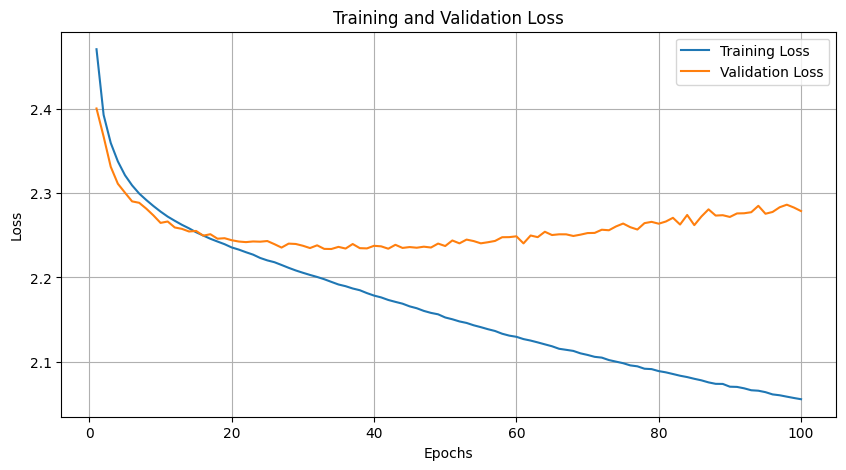

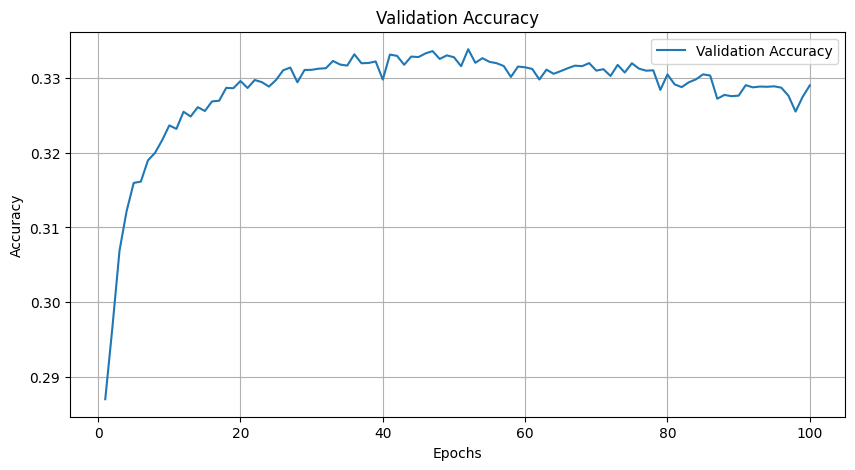

Predicted next character: 'o'
Training time:5506.749595165253 seconds
Trainable parameters: 1202753
Total trainable parameters in the model: 1202753


In [4]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 50
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]


dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded.permute(1, 0, 2))  # Permute for Transformer
        output = self.fc(transformer_output[-1, :, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 2
nhead = 1
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            val_loss += criterion(outputs, targets).item()

    end_time = time.time()
    training_time = end_time - start_time

    # Calculate Epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    # Append loss and accuracy values
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # Print Epoch statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_int[c] for c in initial_str[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
total_complexity = 0
for p in model.parameters():
    total_complexity += torch.prod(torch.tensor(p.shape))


# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"Trainable parameters: {count_parameters(model)}")
print(f"Total trainable parameters in the model: {total_complexity}")

Increasing hidden size and Number of Layers

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10, Loss: 2.9768267437020595, Validation Loss: 3.1555549062946646, Validation Accuracy: 0.13483030218807296
Epoch 20, Loss: 3.015912375741489, Validation Loss: 3.1750892743391343, Validation Accuracy: 0.17673586673420807
Epoch 30, Loss: 2.971952767428214, Validation Loss: 2.9640698266043035, Validation Accuracy: 0.191331985493538
Epoch 40, Loss: 2.9574179018084097, Validation Loss: 2.963568948974434, Validation Accuracy: 0.18212872019473447
Epoch 50, Loss: 2.912114998491345, Validation Loss: 2.928467690910475, Validation Accuracy: 0.1954741273036181
Epoch 60, Loss: 2.9408252063798823, Validation Loss: 2.9487097683270225, Validation Accuracy: 0.18164457374940043
Epoch 70, Loss: 2.9896956017765586, Validation Loss: 2.987988910932207, Validation Accuracy: 0.16832606366525757
Epoch 80, Loss: 2.934499874685389, Validation Loss: 3.036835192402956, Validation Accuracy: 0.16391495160776964
Epoch 90, Loss: 2.920203704397636, Validation Loss: 2.927557028372672, Validation Accuracy: 0.19160

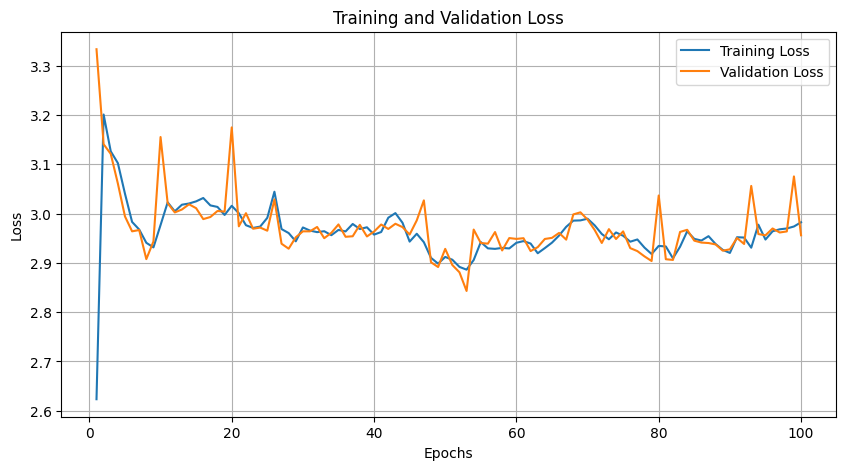

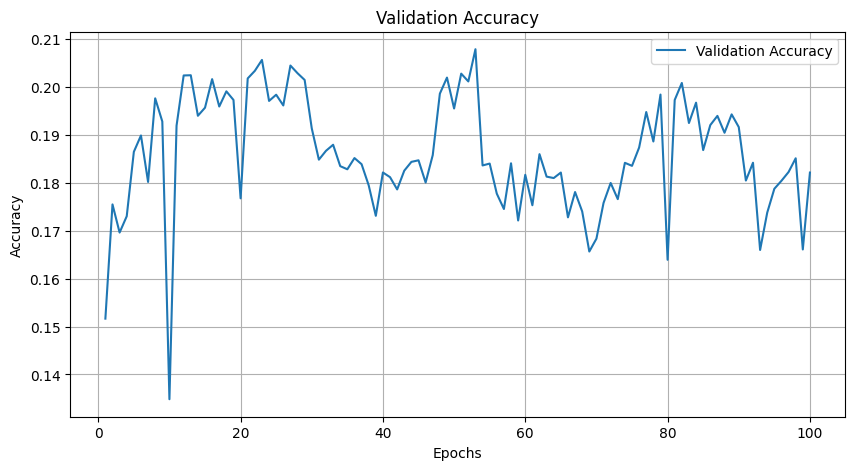

Predicted next character: 't'
Training time:10210.049714565277 seconds
Trainable parameters: 3978561
Total trainable parameters in the model: 3978561


In [3]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 30
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded.permute(1, 0, 2))  # Permute for Transformer
        output = self.fc(transformer_output[-1, :, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 256
num_layers = 3
nhead = 1
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            val_loss += criterion(outputs, targets).item()

    end_time = time.time()
    training_time = end_time - start_time

    # Calculate Epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    # Append loss and accuracy values
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # Print Epoch statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_int[c] for c in initial_str[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
total_complexity = 0
for p in model.parameters():
    total_complexity += torch.prod(torch.tensor(p.shape))


# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"Trainable parameters: {count_parameters(model)}")
print(f"Total trainable parameters in the model: {total_complexity}")